In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/rohaan/Desktop/storage/RIT/federated_learning_lab/federated_learning'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import json
import numpy as np
import random

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)           # For CPU
    torch.cuda.manual_seed(seed)      # For CUDA (if using GPU)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    np.random.seed(seed)              # For NumPy
    random.seed(seed)                 # For Python's built-in random
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Turn off optimization for reproducibility

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 as required by LeNet-5
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f"Datasets:\n\t-> TRAIN: {'available' if train_dataset else 'N/A'}\n\t-> TEST: {'available' if train_dataset else 'N/A'}")

Datasets:
	-> TRAIN: available
	-> TEST: available


In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

print(f"Datasets:\n\t-> TRAIN: {len(train_loader.dataset)} samples\n\t-> TEST: {len(test_loader.dataset)} samples")

Datasets:
	-> TRAIN: 60000 samples
	-> TEST: 10000 samples


In [6]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # kernel_size aka filter size
        # out_channels aka number of filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = torch.tanh(x) 
        # layer 2
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 3
        x = self.conv2(x)
        x = torch.tanh(x) 
        # layer 4
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 5
        x = self.conv3(x)
        x = torch.tanh(x) 
        # layer 6
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.tanh(x) 
        # output layer
        x = self.fc2(x)
        # x = nn.functional.softmax(x, dim=1)  # remove softmax if using crossEntropy since it applies the softmax function too
    
        return x

In [7]:
def train(model, device, train_loader, optimizer, criterion, epoch, track_weights=False):
    model.train()
    train_loss = 0
    
    w_t = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}')

    avg_train_loss = train_loss / len(train_loader.dataset)
    
    if track_weights:
        # Initialize to store the previous weights
        w_t_plus_1 = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
        weight_updates = {
            name: (w_t[name] - w_t_plus_1[name]).tolist() 
            for name in w_t_plus_1
        }
        with open(f'save/LeNet5/updates_epoch_{epoch}.json', 'w') as json_file:
            json.dump(weight_updates, json_file)
    
    return avg_train_loss

In [8]:
def initialize_model(seed=42):
    # Set the seed for reproducible results
    set_seed(seed)
    model = LeNet5()
    return model

In [9]:
model = initialize_model(seed=1829).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return avg_test_loss, accuracy

In [11]:
num_epochs = 5

train_losses = []
test_losses = []
accuracies = []

for epoch in range(1, 1 + num_epochs):
    avg_train_loss = train(model, device, train_loader, optimizer, criterion, epoch, track_weights=True)
    avg_test_loss, accuracy = test(model, device, test_loader)
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [0/60000]	Loss: 2.306540
Train Epoch: 1 [6400/60000]	Loss: 0.202203
Train Epoch: 1 [12800/60000]	Loss: 0.471449
Train Epoch: 1 [19200/60000]	Loss: 0.070377
Train Epoch: 1 [25600/60000]	Loss: 0.287195
Train Epoch: 1 [32000/60000]	Loss: 0.180319
Train Epoch: 1 [38400/60000]	Loss: 0.106414
Train Epoch: 1 [44800/60000]	Loss: 0.342011
Train Epoch: 1 [51200/60000]	Loss: 0.484629
Train Epoch: 1 [57600/60000]	Loss: 0.438163

Test set: Average loss: 0.0001, Accuracy: 9625/10000 (96%)

Train Epoch: 2 [0/60000]	Loss: 0.097906
Train Epoch: 2 [6400/60000]	Loss: 0.079396
Train Epoch: 2 [12800/60000]	Loss: 0.186872
Train Epoch: 2 [19200/60000]	Loss: 0.071210
Train Epoch: 2 [25600/60000]	Loss: 0.032950
Train Epoch: 2 [32000/60000]	Loss: 0.166382
Train Epoch: 2 [38400/60000]	Loss: 0.008771
Train Epoch: 2 [44800/60000]	Loss: 0.080362
Train Epoch: 2 [51200/60000]	Loss: 0.059575
Train Epoch: 2 [57600/60000]	Loss: 0.108272

Test set: Average loss: 0.0001, Accuracy: 9639/10000 (96%)

Train Ep

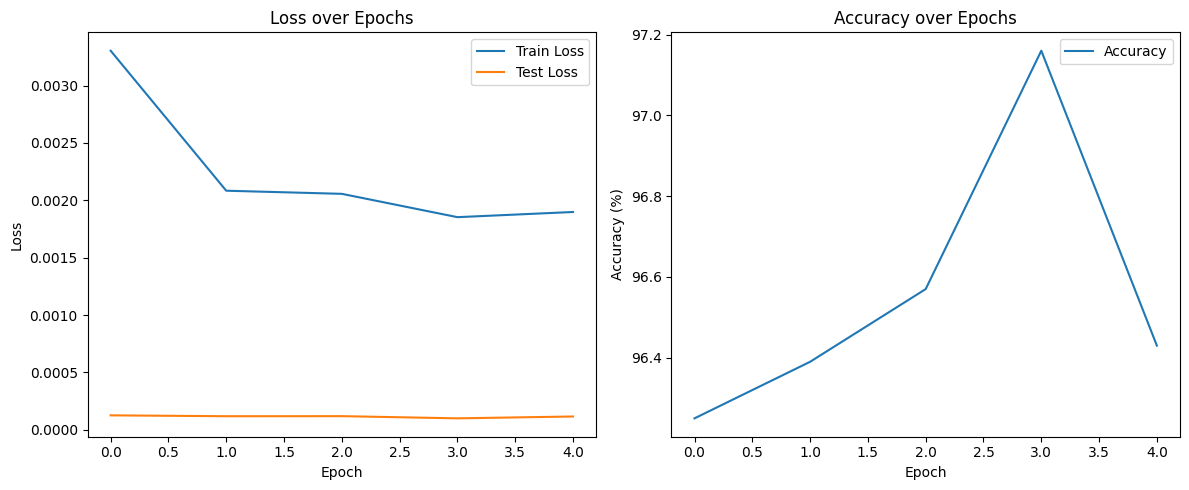

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()